# Importación de librerías

In [1]:
import pandas as pd
import numpy as np

# Importación de raw_data.csv

In [191]:
df = pd.read_csv("/content/raw_data.csv")
df.head(3)

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket
0,perfumeria_e_higiene_cuidado_facial_protector_...,LIPOSAN protector labial soft rose envase 1 ud,NaN,2.39,2.39,ud,2021-03-06 00:00:00,45d83ce427cf60c02e1e6f3d28f58ed6,M3
1,perfumeria_e_higiene_higiene_intima_compresas,AUSONIA compresas normal alas bolsa 14 uds,NaN,2.49,0.18,ud,2021-03-06 00:00:00,3fa10738dcbe5f09646eaf39a46a2871,M3
2,perfumeria_e_higiene_higiene_intima_compresas,EVAX Cottonlike compresa super plus con alas b...,NaN,2.79,0.23,ud,2021-03-06 00:00:00,5f5bc0a466375a16d01a6aed6c66e413,M3


# Análisis inicial del DataFrame

### Dimensión, estructura y tipos de datos

Utilizamos df.info() para mostrar la estructura del DataFrame. Este paso nos permite:

1. Ver cuántas filas y columnas tiene el conjunto de datos

2. Identificar los tipos de datos

3. Detectar columnas que deben ser convertidas, como insert_date (que debería ser tipo fecha)

4. Evaluar el uso de memoria

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8223992 entries, 0 to 8223991
Data columns (total 9 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   category                  object 
 1   name                      object 
 2   description               object 
 3   price                     float64
 4   reference_price           float64
 5   reference_unit            object 
 6   insert_date               object 
 7   product_id                object 
 8   id_reference_supermarket  object 
dtypes: float64(2), object(7)
memory usage: 564.7+ MB


### Duplicados y nulos

Eliminamos filas duplicadas completas, es decir, aquellas donde todos los valores de todas las columnas son iguales.

In [193]:
df = df.drop_duplicates()

In [194]:
df.shape[0]

8223989

Tras ejecutar df.drop_duplicates(), el número de filas se redujo en 3. Esto indica que existían 3 registros completamente duplicados, idénticos en todas las columnas.

Calculamos el número de valores nulos por cada columna. Este análisis nos ayuda a identificar columnas que necesitan una limpieza o transformación adicional.

In [195]:
df.isnull().sum()

,0
category,0
name,98
description,5201514
price,18
reference_price,6
reference_unit,5480
insert_date,0
product_id,0
id_reference_supermarket,0


Tenemos 5 columnas con nulos. Las de nombre y de precio de productos son fundamentales y la de descripcion no tiene tanta importancia para analisis posterior.

# Detección y corrección de anomalías en los precios

### Análisis exploratorio de precios

Analizamos la distribución general de los precios. El resumen estadístico de las columnas price y reference_price nos permite detectar anomalías como valores extremos, alta dispersión, etc.


In [196]:
df[['price', 'reference_price']].describe()

,price,reference_price
count,8.223971e+06,8.223983e+06
mean,4.752582e+00,1.934868e+01
std,4.889752e+01,6.267921e+02
min,8.000000e-02,3.000000e-03
25%,1.390000e+00,1.800000e+00
50%,2.200000e+00,4.556000e+00
75%,3.990000e+00,9.920000e+00
max,7.915050e+03,1.633333e+05


El análisis estadístico de las columnas price (precio del producto) y reference_price (precio por unidad de medida, como €/kg o €/l) revela los siguientes aspectos importantes:

- el precio medio es 4.75, pero la desviación estándar (48.9) indica una gran dispersión;

- el valor máximo de price es 7915, lo cual es inusualmente alto comparado con la mediana (2.2).

Esto indica una distribución muy sesgada hacia la derecha (hay pocos valores extremadamente altos que elevan la media). Existen precios extremadamente elevados que probablemente no son realistas.

El campo reference_price también muestra una anomalía: su máximo es 163333, mientras que la mediana es 4.5. La desviación estándar es extremadamente alta, lo cual es una señal clara de que hay valores atípicos o mal registrados.

Este resumen estadístico muestra claramente la presencia de valores anómalos y atípicos que deben ser tratados antes de continuar con el análisis. El siguiente paso será identificar, visualizar y tratar los valores atípicos para garantizar la calidad del dataset y evitar conclusiones erróneas en análisis posteriores.

Con el objetivo de detectar visualmente la presencia de valores extremos o errores de registro en los precios, generamos dos diagramas de caja: boxplot del campo price y boxplot del campo reference_price.

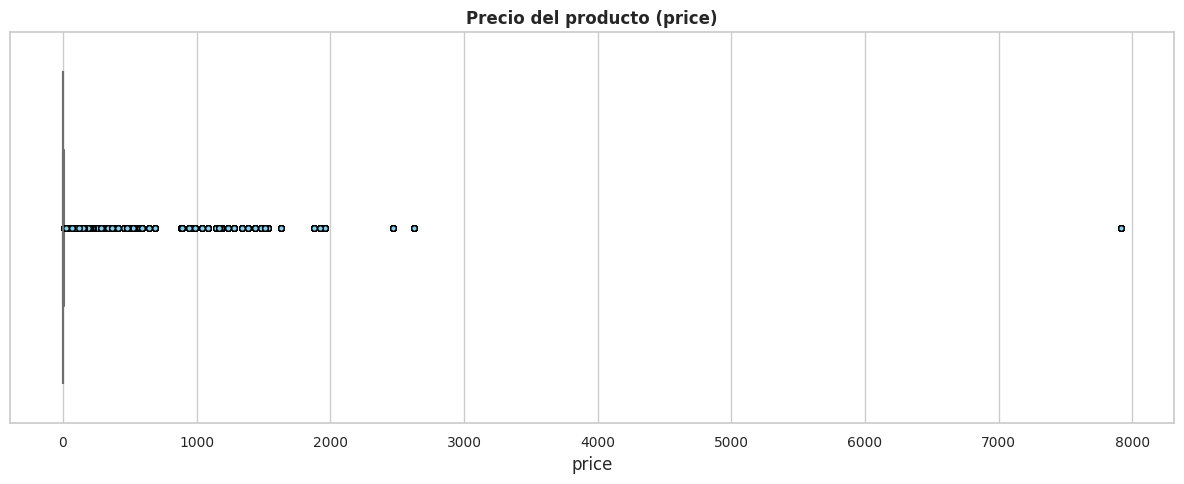

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="pastel")

flier_props = dict(marker='o', markerfacecolor='skyblue', markersize=4, linestyle='none', markeredgecolor='black')

plt.figure(figsize=(12, 5))
sns.boxplot(
    x=df['price'],
    color='skyblue',
    fliersize=4,
    linewidth=1.5,
    flierprops=flier_props
)

plt.title('Precio del producto (price)', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Podemos ver que la mayoría de los productos se concentran en un rango bajo de precios. Sin embargo, hay numerosos valores extremos que superan ampliamente los 1000€, llegando incluso a precios superiores a 7000€. Estos valores son claramente atípicos y probablemente se deben a errores de registro.

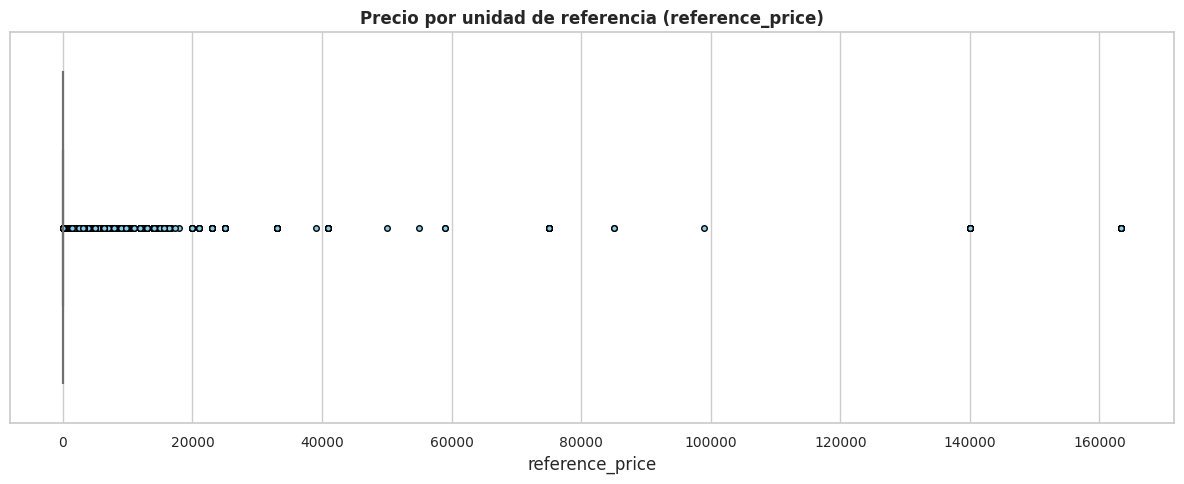

In [199]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    x=df['reference_price'],
    color='skyblue',
    fliersize=4,
    linewidth=1.5,
    flierprops=flier_props)

plt.title('Precio por unidad de referencia (reference_price)', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

Este indicador también presenta una gran cantidad de outliers. Se observan precios por unidad superiores a 20000€, lo cual resulta claramente irreal. El comportamiento observado confirma lo ya detectado en el resumen estadístico: existe una gran dispersión que puede sesgar el análisis si no se corrige.

Ambas variables contienen valores atípicos extremos que deben ser tratados con precaución.

### Identificación y eliminación de valores atípicos usando IQR

Antes de eliminar o modificar valores extremos, es importante definir qué se considera un valor atípico. Para ello, utilizamos el método estadístico del rango intercuartílico (IQR), una técnica robusta común en el análisis exploratorio de datos. Se calcula el primer cuartil (Q1) y el tercer cuartil (Q3), y el IQR es la diferencia entre ellos (IQR = Q3 - Q1). En lugar del coeficiente estándar 1.5, en este caso utilizamos un valor más flexible: 6, lo que nos permite conservar una mayor cantidad de datos y evitar la eliminación excesiva de observaciones válidas. Con este coeficiente, consideramos valores atípicos aquellos que se encuentran por debajo de Q1 - 6 × IQR o por encima de Q3 + 6 × IQR. Obtenemos así los límites inferior y superior que se utilizarán en la siguiente etapa para identificar y tratar valores extremos.

In [ ]:
# Función para calcular los límites del IQR
def calcular_limites_iqr(columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 6 * IQR
    limite_superior = Q3 + 6 * IQR
    return limite_inferior, limite_superior

limite_inferior_price, limite_superior_price = calcular_limites_iqr('price')
limite_inferior_ref_price, limite_superior_ref_price = calcular_limites_iqr('reference_price')

In [ ]:
# Identificamos los valores atípicos en la columna 'price'
outliers_price = df[(df['price'] < limite_inferior_price) | (df['price'] > limite_superior_price)]

# Identificamos los valores atípicos en la columna 'reference_price'
outliers_ref_price = df[(df['reference_price'] < limite_inferior_ref_price) | (df['reference_price'] > limite_superior_ref_price)]

# Mostramos la cantidad de valores atípicos detectados
print("Valores atípicos en price:", len(outliers_price))
print("Valores atípicos en reference_price:", len(outliers_ref_price))

Valores atípicos en price: 111278
Valores atípicos en reference_price: 183260


Esto representa una parte importante del dataset, lo cual confirma la presencia de anomalías en los precios. Estas anomalías podrían deberse a errores en los datos o a formatos de presentación diferentes (por ejemplo, productos a granel o en grandes cantidades).

En proximo paso creamos un nuevo DataFrame llamado df_clean, que contiene solo las filas cuyos valores de price están dentro de los límites válidos definidos por el IQR. De esta forma eliminamos los valores atípicos — aquellos que son demasiado bajos o demasiado altos y que podrían distorsionar el análisis. Se aplican las siguientes condiciones: price debe estar entre limite_inferior_price y limite_superior_price. El método .copy() asegura que trabajamos con una copia independiente de los datos filtrados.

In [ ]:
# Filtramos las filas según los límites del rango intercuartílico (IQR)
df_clean = df[
    (df['price'] >= limite_inferior_price) & (df['price'] <= limite_superior_price) &
    (df['reference_price'] >= limite_inferior_ref_price) & (df['reference_price'] <= limite_superior_ref_price)
].copy()

In [ ]:
df_clean.describe()

,price,reference_price
count,7.951345e+06,7.951345e+06
mean,3.103018e+00,7.032845e+00
std,2.786101e+00,8.184911e+00
min,8.000000e-02,3.000000e-03
25%,1.350000e+00,1.750000e+00
50%,2.160000e+00,4.389000e+00
75%,3.870000e+00,9.190000e+00
max,1.959000e+01,5.857000e+01


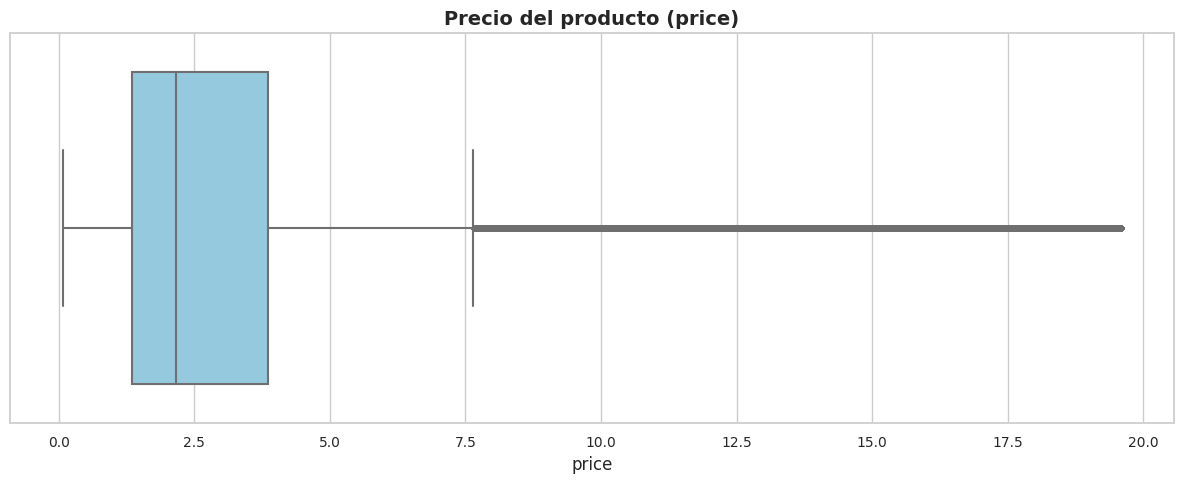

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    x=df_clean['price'],
    color='skyblue',
    fliersize=3,
    linewidth=1.5
)
plt.title('Precio del producto (price)', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
num_unique_id = df['product_id'].nunique()
num_unique_id

34071

In [ ]:
num_unique_id_clean = df_clean['product_id'].nunique()
num_unique_id_clean

32272

En la etapa de limpieza aplicamos el método del rango intercuartílico (IQR) con un coeficiente de 6 para eliminar outliers. Sin embargo, esta estrategia fue demasiado restrictiva: de 34071 productos únicos, tras la limpieza quedaron sólo 32272, lo que significa una pérdida de 1799 productos.

El análisis del sitio web de Carrefour reveló que muchos artículos con precios superiores a 20€ no eran errores, sino productos legítimos como:

- cosméticos de alta gama,

- botellas de alcohol caro,

- pescado entero (como el salmón de 3 kg),

- y especialmente piernas de jamón ibérico, cuyo precio puede alcanzar los 700€.

Por tanto, en lugar de eliminar sistemáticamente los valores extremos, decidimos estudiar las categorías con precios medios más altos. Esto nos permite identificar patrones comunes en productos costosos y aplicar correcciones más precisas y justas.

### Revisión de productos con precios desproporcionados

Vamos explorar las categorías que presentan los valores medios más altos. Esta observación nos puede ayudar a detectar patrones comunes entre los productos con precios extremos y, si es posible, aplicar correcciones sistemáticas en lugar de tratar cada producto por separado.

In [200]:
# Agrupamos los productos por categoría y calculamos el precio medio
top_10_categorias = (
    df.groupby('category')['price']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index())

top_10_categorias

,category,price
0,congelados_marisco,352.093866
1,productos_frescos_charcuteria_rincon_del_jamon,236.513661
2,la_despensa_cestas_y_lotes_lotes_de_jamon,107.897541
3,marisco_y_pescado_marisco,100.116659
4,el_mercado_charcuteria_jamon_serrano_e_iberico...,99.434728
5,productos_frescos_carniceria_piezas_enteras_si...,89.939379
6,productos_frescos_charcuteria_jamon_serrano_e_...,78.230049
7,limpieza_y_hogar_menaje_cafeteras_y_accesorios,55.519060
8,charcuteria_y_quesos_jamon_serrano,47.747233
9,limpieza_y_hogar_menaje_ollas_cazos_y_accesorios,40.438670


Como resultado del análisis previo, mostramos la tabla con las 10 categorías que presentan el precio promedio más alto. Entre ellas se encuentran productos congelados, embutidos ibéricos y lotes especiales, que podrían incluir artículos de lujo o errores de entrada de datos. Para entender mejor el comportamiento de estas categorías y verificar si los precios elevados son reales o erróneos, vamos a explorar en detalle los productos dentro de las primeras categorías del ranking.

In [201]:
categoria = 'congelados_marisco'

top_10_categoria = (
    df[df['category'] == categoria]
    .sort_values('price', ascending=False)
    .drop_duplicates('product_id')
    .head(10))

top_10_categoria

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket
1868962,congelados_marisco,Carabinero congelado,Granel,7915.05,79.95,kg,2021-06-30 00:00:00,aa8de147e283c68f9b81ba55ef8bab49,M1
3669456,congelados_marisco,Alistado mediano congelado,Granel,2623.50,26.50,kg,2021-11-03 00:00:00,061743acc8d5c3b83c2b2578af5bc930,M1
7372679,congelados_marisco,Bocas de cangrejo pequeñas congeladas,Granel,1960.20,19.80,kg,2022-07-16 00:00:00,4a8c644f154514ed0ea037a647eeb62f,M1
8218777,congelados_marisco,Gamba blanca congelada,Granel,1925.55,19.45,kg,2022-09-15 00:00:00,bf3cccbc52f49b3eab264679ed518d86,M1
4854694,congelados_marisco,Cuerpos chicos de cangrejo Dimarosa congelados,Granel,1633.50,16.50,kg,2022-01-22 00:00:00,3796c7ec2e71ea615360480bcbbe9bfd,M1
2926634,congelados_marisco,Bocas chicas de cangrejos congeladas,Granel,1633.50,16.50,kg,2021-09-11 00:00:00,e24bb6aacfc47dc32d1ac70ba2358836,M1
5680360,congelados_marisco,Alistado pequeño congelado,Granel,1514.70,15.30,kg,2022-03-20 00:00:00,9d90ddbb171b5559fb818c838bf05049,M1
5407628,congelados_marisco,Gamba arrocera congelada,Granel,1381.05,13.95,kg,2022-03-01 00:00:00,5d2063c57035c998ac64bb0a52329e1a,M1
7070522,congelados_marisco,Gambón congelado,Granel,1188.00,12.00,kg,2022-06-24 00:00:00,8b0793784bbdc0896d4af88649f376c1,M1
7686875,congelados_marisco,Gambón grande congelado,Granel,955.35,9.65,kg,2022-08-07 00:00:00,63f8ec4d3e081e203945890906b2ed90,M1


In [202]:
categoria = 'marisco_y_pescado_marisco'

top_10_categoria = (
    df[df['category'] == categoria]
    .sort_values('price', ascending=False)
    .drop_duplicates('product_id')
    .head(10))

top_10_categoria

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket
3577821,marisco_y_pescado_marisco,Alistado mediano congelado,Granel,2623.50,26.50,kg,2021-10-28 00:00:00,061743acc8d5c3b83c2b2578af5bc930,M1
3577816,marisco_y_pescado_marisco,Gamba blanca congelada,Granel,1925.55,19.45,kg,2021-10-28 00:00:00,bf3cccbc52f49b3eab264679ed518d86,M1
4508777,marisco_y_pescado_marisco,Cuerpos chicos de cangrejo Dimarosa congelados,Granel,1633.50,16.50,kg,2021-12-29 00:00:00,3796c7ec2e71ea615360480bcbbe9bfd,M1
3577767,marisco_y_pescado_marisco,Bocas chicas de cangrejos congeladas,Granel,1633.50,16.50,kg,2021-10-28 00:00:00,e24bb6aacfc47dc32d1ac70ba2358836,M1
5736312,marisco_y_pescado_marisco,Alistado pequeño congelado,Granel,1514.70,15.30,kg,2022-03-23 00:00:00,9d90ddbb171b5559fb818c838bf05049,M1
4508750,marisco_y_pescado_marisco,Gamba arrocera congelada,Granel,1381.05,13.95,kg,2021-12-29 00:00:00,5d2063c57035c998ac64bb0a52329e1a,M1
5736310,marisco_y_pescado_marisco,Gambón congelado,Granel,1188.00,12.00,kg,2022-03-23 00:00:00,8b0793784bbdc0896d4af88649f376c1,M1
7693411,marisco_y_pescado_marisco,Langostino cocido,Granel,1183.05,11.95,kg,2022-08-08 00:00:00,0cb5f24dff7d93467fc508b58121e435,M1
4135054,marisco_y_pescado_marisco,Langostino cocido,Granel,1084.05,10.95,kg,2021-12-04 00:00:00,bbe74d6413184332f4e7f0d973770a24,M1
852204,marisco_y_pescado_marisco,Langostino crudo ultracongelado,Granel,940.50,9.50,kg,2021-04-21 00:00:00,1fc4cf0f8648a70833c9f7a9af3bf807,M1


In [89]:
categoria = 'productos_frescos_charcuteria_rincon_del_jamon'

top_10_categoria = (
    df[df['category'] == categoria]
    .sort_values('price', ascending=False)
    .drop_duplicates('product_id')
    .head(10))

top_10_categoria

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket
6846148,productos_frescos_charcuteria_rincon_del_jamon,Jamón de bellota ibérico 100% raza ibérica pie...,NaN,409.0,62.92,kg,2022-06-08 00:00:00,474f6f2fb3f25764a4f24b05bd480ce1,M2
6758631,productos_frescos_charcuteria_rincon_del_jamon,Paleta de bellota ibérica 100% raza ibérica pi...,NaN,219.0,46.11,kg,2022-06-02 00:00:00,497bf1413a9f62323fb6c78717a7edfe,M2
5111169,productos_frescos_charcuteria_rincon_del_jamon,Jamón de cebo ibérico 50 % raza ibérica pieza ...,NaN,175.0,23.33,kg,2022-02-09 00:00:00,f20afa3508c416d0d22efadf4c72544d,M2
6778363,productos_frescos_charcuteria_rincon_del_jamon,Jamón ibérico de cebo 50% raza ibérica Calidad...,NaN,149.0,21.29,kg,2022-06-04 00:00:00,ae752822ae4f15b27f63319b26770b75,M2
6615432,productos_frescos_charcuteria_rincon_del_jamon,Jamón de cebo ibérico 50% raza ibérica Legado ...,NaN,149.0,19.87,kg,2022-05-23 00:00:00,45d322bf19de43d4b7eedb5ca5780fff,M2
5111155,productos_frescos_charcuteria_rincon_del_jamon,Jamón de cebo ibérico de campo 50% raza ibéric...,NaN,149.0,19.87,kg,2022-02-09 00:00:00,e49293b00826f3dfa7d9577897679769,M2


Durante el análisis detallado de las categorías con precios más altos, observamos un patrón claro: muchos productos presentan un precio total que es hasta 100 veces mayor que su precio por kilogramo. Esta discrepancia indica un posible error sistemático en la ubicación del separador decimal, es decir, la coma podría estar mal posicionada. Sin embargo, también identificamos productos cuyo alto precio sí parece realista, como, por ejemplo, jamón ibérico de alta calidad.

### Corrección de valores sospechosos en el precio del producto (price)

Como reveló el análisis anterior, algunos productos presentan valores anormalmente altos en la columna price, que difieren en órdenes de magnitud de su reference_price. Este patrón sugiere un posible error tipográfico, como una coma mal colocada. Para evitar eliminar datos valiosos, decidimos aplicar una corrección en lugar de eliminar estas filas. Se aplicaron los siguientes criterios para identificar los errores:

- unidad de referencia: kilogramos (reference_unit = kg),

- price supera 90 veces al reference_price,

- price es mayor a 30 euros,

- y el nombre del producto no contiene la palabra "jamón" o "bellota", ya que los jamones pueden tener precios elevados reales.

Para los registros que cumplen esta condición, dividimos el valor de price por 100 y marcamos estas filas con un nuevo indicador price_corrected = True.


In [203]:
# Condición para detectar errores de precio
condicion_correccion = (
    (df['reference_unit'] == 'kg') &
    ((df['price'] / df['reference_price']) > 90) &
    (df['price'] > 30) &
    (~df['name'].str.contains('jamón|bellota', case=False, na=False)))

# Mostramos cuántas filas se van a corregir
print(f"Productos corregidos: {condicion_correccion.sum()}")

# Aplicamos corrección dividiendo el precio por 100
df.loc[condicion_correccion, 'price'] = df.loc[condicion_correccion, 'price'] / 100

# Añadimos una nueva columna con un flag de corrección
df['price_corrected'] = False
df.loc[condicion_correccion, 'price_corrected'] = True

Productos corregidos: 6498


In [151]:
df.describe()

,price,reference_price
count,8.223971e+06,8.223983e+06
mean,3.669440e+00,1.934868e+01
std,7.720471e+00,6.267921e+02
min,8.000000e-02,3.000000e-03
25%,1.390000e+00,1.800000e+00
50%,2.200000e+00,4.556000e+00
75%,3.990000e+00,9.920000e+00
max,5.950000e+02,1.633333e+05


Como resultado, se corrigieron 6498 filas. Ahora el valor máximo de price es de 595€, lo cual es coherente con el precio de una pierna de jamón ibérico de alta calidad. Esta corrección mejora significativamente la calidad de los datos sin perder observaciones valiosas para el análisis posterior.

In [92]:
# Top-10 productos más caros
top_10 = df.sort_values('price', ascending=False).drop_duplicates('product_id').head(10)
top_10.head(10)

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket,price_corrected
5114445,limpieza_y_hogar_bazar_barbacoas_y_accesorios,Barbacoa de Pellets - 130x55x120 Cm / 54 kg,NaN,595.00,595.000,ud,2022-02-09 00:00:00,07a4e9178ceb42cb5be73b99d19433ac,M2,False
7990009,charcuteria_y_quesos_jamon_serrano,Jamón de bellota ibérico 100% Campo Extremadura,Pieza,479.75,50.500,kg,2022-08-29 00:00:00,cedbc2de52a22b98dc25f28f37770b16,M1,False
5138241,limpieza_y_hogar_bazar_barbacoas_y_accesorios,Barbacoa Vertical con Chimena y Ladrillos Refr...,NaN,459.00,459.000,ud,2022-02-10 00:00:00,1fb6af387252cfee9a15c6e29a518d9f,M2,False
5111252,productos_frescos_charcuteria_rincon_del_jamon,Jamón de bellota ibérico 100% raza ibérica pie...,NaN,409.00,62.920,kg,2022-02-09 00:00:00,474f6f2fb3f25764a4f24b05bd480ce1,M2,False
7495662,charcuteria_y_quesos_jamon_serrano,Jamón de bellota ibérico 50% La Hacienda del i...,Pieza,369.00,41.000,kg,2022-07-25 00:00:00,7b38fa5c0b063a58a3f4929148f90628,M1,False
6035838,productos_frescos_charcuteria_jamon_serrano_e_...,Jamón ibérico bellota 100% raza ibérica 10 Vet...,NaN,339.00,56.500,kg,2022-04-13 00:00:00,7ffde7e82c32c4dbd84d417e73ca1cc4,M2,False
4340265,charcuteria_y_quesos_jamon_serrano,Jamón de bellota ibérico 100% Covap,Pieza,290.00,38.667,kg,2021-12-18 00:00:00,ec6e211f1a6e10619ed68a27157e1381,M1,False
7378303,frescos_charcuteria_y_quesos_curados,NOBLEZA EXTREMEÑA jamón de bellota 100% ibéric...,NaN,289.00,38.530,kg,2022-07-16 00:00:00,4c51d734b50c903bc2130e9ab8f5875d,M3,False
6806755,productos_frescos_charcuteria_rincon_del_jamon,Paleta de bellota ibérica 100% raza ibérica pi...,NaN,219.00,46.110,kg,2022-06-06 00:00:00,497bf1413a9f62323fb6c78717a7edfe,M2,False
277467,el_mercado_charcuteria_jamon_serrano_e_iberico...,Jamón ibérico de bellota 50% raza ibérica piez...,NaN,215.00,26.870,kg,2021-03-19 00:00:00,31fe5ca437156bc6ef37a4b96da4e81e,M2,False


Miramos tambien otros productos más caros

In [152]:
# Filtramos los productos que no contienen 'jamón' o 'bellota' en el nombre
filtro_no_jamon = ~df['name'].str.contains('jamón|bellota', case=False, na=False)

# Seleccionamos el top-10 de productos más caros, excluyendo jamón
top_10_sin_jamon = df[filtro_no_jamon].sort_values('price', ascending=False).drop_duplicates('product_id').head(10)
top_10_sin_jamon

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket,price_corrected
5114445,limpieza_y_hogar_bazar_barbacoas_y_accesorios,Barbacoa de Pellets - 130x55x120 Cm / 54 kg,NaN,595.00,595.00,ud,2022-02-09 00:00:00,07a4e9178ceb42cb5be73b99d19433ac,M2,False
5138241,limpieza_y_hogar_bazar_barbacoas_y_accesorios,Barbacoa Vertical con Chimena y Ladrillos Refr...,NaN,459.00,459.00,ud,2022-02-10 00:00:00,1fb6af387252cfee9a15c6e29a518d9f,M2,False
7370972,productos_frescos_carniceria_piezas_enteras_si...,Tapa de añojo pieza entera Calidad y Origen Ca...,NaN,149.90,14.99,kg,2022-07-16 00:00:00,36ee9042cfe3223d2b8a3fe96b7b534c,M2,False
5138259,limpieza_y_hogar_bazar_barbacoas_y_accesorios,Barbacoa Mi Paella,NaN,149.00,149.00,ud,2022-02-10 00:00:00,edd2721512c753e64b8dfcb9cf12468a,M2,False
345802,limpieza_y_hogar_menaje_ollas_cazos_y_accesorios,Batería Acero Inoxidable MASTERPRO Triply 6 pzas,NaN,140.00,140000.00,ud,2021-03-23 00:00:00,c39e65836c869cc8f3a43e944d19a4ed,M2,False
7767907,productos_frescos_carniceria_piezas_enteras_si...,Lomo alto de añojo limpio pieza/entera sin cor...,NaN,132.23,18.89,kg,2022-08-13 00:00:00,929f96e96ab12946be107333a0211971,M2,False
5682785,limpieza_y_hogar_menaje_ollas_cazos_y_accesorios,Olla a Presión de Acero Inoxidable SAN IGNACIO...,NaN,125.00,125.00,ud,2022-03-20 00:00:00,816cf4660a76353436da1185014ef6c9,M2,False
3533844,la_despensa_cestas_y_lotes_cestas_de_navidad,Lote de Navidad nº 18,NaN,125.00,125.00,ud,2021-10-25 00:00:00,ef3a579603a510c797a4626a40e222cd,M2,False
4590260,limpieza_y_hogar_bazar_pequeno_electrodomestico,Cafetera Krups Genios S Plus KP3408 - Negro,NaN,119.00,119.00,ud,2022-01-04 00:00:00,9f4097163c0188317f373c68de60d410,M2,False
4590272,limpieza_y_hogar_bazar_pequeno_electrodomestico,Cafetera Delonghi Dolce Gusto Genio Plus EDG31...,NaN,119.00,119.00,ud,2022-01-04 00:00:00,fd0c2421ac0d620e032e077a4f3925de,M2,False


Tras aplicar todas las estrategias de detección y corrección de valores atípicos, el rango actual de precios en la columna price es mucho más coherente y realista. Los valores máximos ahora corresponden al tipo de productos: jamones enteros, barbacoas, electrodomésticos para el hogar, utensilios de cocina, etc. Esto confirma que las correcciones aplicadas fueron adecuadas y han permitido conservar la calidad del dataset para un análisis posterior fiable.

Es importante revisar también los productos con los valores más bajos de price. Este análisis nos permite detectar posibles errores en el rango inferior, como precios inusualmente bajos causados por errores de entrada o redondeo. A continuación, se muestran los 10 productos con el precio más bajo del conjunto de datos.

In [60]:
# Seleccionamos los 10 productos con el precio más bajo
top_10_mas_baratos = df.sort_values('price', ascending=True).drop_duplicates('product_id').head(10)
top_10_mas_baratos

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket,price_corrected
4397792,panaderia_y_pasteleria_bolleria_envasada,Bolitas de coco Antiu Xixona,NaN,0.08,4.000,kg,2021-12-22 00:00:00,fa55a2b65f98bed89d6ae39489ba050b,M1,False
4526182,dulces_de_navidad_calendario_de_adviento,DIA DULCE NOEL hojaldrada clásica surtido 25 gr,NaN,0.08,3.160,kg,2021-12-31 00:00:00,71d41f36f771940a30099fefc8515dac,M3,False
4721623,dulces_de_navidad_turrones,DIA DULCE NOEL almendra rellena surtido 10 gr,NaN,0.08,7.740,kg,2022-01-13 00:00:00,dc24634b1094530787e63d6c1d7f2363,M3,False
3917423,panaderia_y_pasteleria_pan_de_horno,Panecillo,NaN,0.10,0.223,100g,2021-11-20 00:00:00,b8e125e39fd5d4e1fd44652721293a30,M1,False
4526215,dulces_de_navidad_calendario_de_adviento,DIA DULCE NOEL rosco de vino surtido 32 gr,NaN,0.10,3.160,kg,2021-12-31 00:00:00,7e69531aacb966c03b1158cd844e1e1c,M3,False
4203509,panaderia_y_pasteleria_bolleria_envasada,Alfajor de almendra La Muralla,NaN,0.11,4.000,kg,2021-12-09 00:00:00,303a0903fdbf1bd935aea30360923e4c,M1,False
3670670,panaderia_y_pasteleria_bolleria_envasada,Rosquillas al cacao Hacendado,NaN,0.12,3.750,kg,2021-11-03 00:00:00,6ee155441fcd66a378673436711953fb,M1,False
4311318,panaderia_y_pasteleria_bolleria_envasada,Hojaldrada La Muralla,NaN,0.12,4.000,kg,2021-12-16 00:00:00,89ffac2d6212dbb11611ccdcaa3a54b2,M1,False
4741220,panaderia_y_pasteleria_bolleria_envasada,Rosco de vino y almendra La Muralla,NaN,0.12,4.000,kg,2022-01-14 00:00:00,edaf1d13b6b89f92a4adf3b05b13f237,M1,False
1277958,panaderia_y_pasteleria_bolleria_envasada,Coquito El Cateto,NaN,0.13,3.750,kg,2021-05-21 00:00:00,c68f9bbdb305379e9eb5b5cd0da541f3,M1,False


En la tabla se observa que los productos con los precios más bajos corresponden a dulces y bollería en porciones pequeñas, como bolitas de coco, turrones y productos navideños. Dado que se trata de unidades individuales con cantidades pequeñas, un precio cercano a 0.08€ resulta completamente razonable. Por tanto, estos valores bajos no deben considerarse errores.

### Detección de errores en el precio por unidad (reference_price)

Después de depurar la columna principal de precios (price), el siguiente paso lógico es revisar los precios por unidad de medida (reference_price). Este campo permite comparar productos de diferentes tamaños o formatos (€/kg, €/l, €/ud), pero también contiene valores anómalos. En algunos registros, reference_price supera los miles o incluso cientos de miles de euros, lo cual no es realista. Para abordar este problema, vamos a:

- explorar el top 10 de categorías con mayor precio de referencia promedio;

- examinar productos en algunas categorías específicas para detectar posibles errores comunes;

- aplicar correcciones o eliminar valores extremos, especialmente aquellos causados por errores de entrada (como decimales mal colocados).

El objetivo es conservar la mayor cantidad de información válida y garantizar la calidad del análisis posterior.

In [204]:
# Agrupamos los productos por categoría y calculamos el reference_precio medio
top_10_categorias = (
    df.groupby('category')['reference_price']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index())
top_10_categorias

,category,reference_price
0,limpieza_y_hogar_bazar_electricidad,4981.645909
1,limpieza_y_hogar_bazar_memorias,2505.783333
2,mascotas_perros_higiene,1739.849398
3,mascotas_perros_comederos,1717.978046
4,mascotas_accesorios_accesorios,1476.591627
5,perfumeria_e_higiene_cuidado_facial_cremas_esp...,1454.725000
6,mascotas_conejos_y_roedores_accesorios_e_higiene,1337.926643
7,limpieza_y_hogar_menaje_ollas_cazos_y_accesorios,1100.217268
8,perfumeria_e_higiene_cuidado_facial_contorno_d...,1054.888597
9,limpieza_y_hogar_menaje_accesorios_para_vino,1004.796667


In [62]:
categoria = 'mascotas_perros_higiene'

top_10_categoria = (
    df[df['category'] == categoria]
    .sort_values('reference_price', ascending=False)
    .drop_duplicates('product_id')
    .head(10))

top_10_categoria

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket,price_corrected
1951153,mascotas_perros_higiene,Pipetas permetrina para perro grande (15-60Kg)...,NaN,15.10,15100.00,ud,2021-07-05 00:00:00,51033eb57343258a1d092095a5d07362,M2,False
2284715,mascotas_perros_higiene,Pipetas permetrina para perro pequeño (1-15Kg)...,NaN,12.29,12290.00,ud,2021-07-28 00:00:00,89d066e625a03ca60cc0f801d965c97d,M2,False
7737211,mascotas_perros_higiene,Pipeta Contra Insectos para Perro Mediano/ Gra...,NaN,4.99,4990.00,ud,2022-08-11 00:00:00,e82b9b5799f84b182fc2c366f11dfe1a,M2,False
5540591,mascotas_perros_higiene,Pipeta Contra Insectos para Perros Pequeños Ca...,NaN,3.95,3950.00,ud,2022-03-10 00:00:00,6d2ccbbdf2643c1355e763541b218765,M2,False
6341134,mascotas_perros_higiene,Toallitas multiusos antibacterias para perros ...,NaN,3.45,3450.00,ud,2022-05-04 00:00:00,0873c537528fdc7573bb08386cacddde,M2,False
6900197,mascotas_perros_higiene,Perfume para perro de melón Kimbo Melón 80 ml,NaN,4.95,61.87,l,2022-06-12 00:00:00,48c443f8a90820d232e5eb262ba2da6e,M2,False
8083015,mascotas_perros_higiene,Perfume para perro de fresa Kimbo París 80 ml,NaN,4.95,61.87,l,2022-09-05 00:00:00,9cc138080dba9b4450f20daec7ce9cdf,M2,False
8083007,mascotas_perros_higiene,Perfume para perro de manzana Kimbo Tokio 80 ml,NaN,4.95,61.87,l,2022-09-05 00:00:00,1a64a7258cad0587aff1b2548cc1c686,M2,False
6900196,mascotas_perros_higiene,Perfume para perro de vainilla Kimbo Cairo 80 ml,NaN,4.95,61.87,l,2022-06-12 00:00:00,b726527f88909ed68362e59ae9c2a12e,M2,False
7927696,mascotas_perros_higiene,Limpiador de oidos para perro Kimbo Bang 100 ml,NaN,4.95,49.50,l,2022-08-25 00:00:00,16c580ad9f1048eac6477ae8835f3b7e,M2,False


In [63]:
categoria = 'mascotas_perros_comederos'

top_10_categoria = (
    df[df['category'] == categoria]
    .sort_values('reference_price', ascending=False)
    .drop_duplicates('product_id')
    .head(10))

top_10_categoria

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket,price_corrected
6848580,mascotas_perros_comederos,Dispensador comida/agua 3500 Ml,NaN,6.15,6150.0,ud,2022-06-09 00:00:00,46e2cb3cc75610cff5d9fcc86e4f5e23,M2,False
5118182,mascotas_perros_comederos,Comedero doble para perro Purina Friskies,NaN,4.70,4700.0,ud,2022-02-09 00:00:00,54607d2262c5a205cab5769f97afc215,M2,False
6961917,mascotas_perros_comederos,Dispensador comida/agua 1500 Ml,NaN,4.60,4600.0,ud,2022-06-16 00:00:00,712473e5a18d7b6a432709089ebc3cc0,M2,False
8217212,mascotas_perros_comederos,Cuenco Chic azul 1L,NaN,3.10,3100.0,ud,2022-09-15 00:00:00,cb55ed4422a6ed6eddce30b20ec2529c,M2,False
6938326,mascotas_perros_comederos,Dispensador comida/agua 500 Ml,NaN,3.10,3100.0,ud,2022-06-15 00:00:00,eba2e69329cb47cec0d04242128bb898,M2,False
7696353,mascotas_perros_comederos,"Cuenco Chic azul 0,65L",NaN,2.69,2690.0,ud,2022-08-08 00:00:00,23a6ca34394b0c21e0a7502a876be6c8,M2,False
8152688,mascotas_perros_comederos,Bowl Color M La Maison Pets,NaN,2.50,2500.0,ud,2022-09-10 00:00:00,d5cdc40e92a81bb7d1fc870059ad9de9,M2,False
7616804,mascotas_perros_comederos,Bowl de Comida Lenta S La Maison Pets,NaN,1.95,1950.0,ud,2022-08-02 00:00:00,dd1a1700cfbc58f2759f2da654054581,M2,False
8132571,mascotas_perros_comederos,"Cuenco Chic azul 0,35L",NaN,1.90,1900.0,ud,2022-09-09 00:00:00,fe2e936ee71d6639d2d6a9514f02b39d,M2,False
347082,mascotas_perros_comederos,Comedero doble para perros de acero inoxidable...,NaN,9.50,9.5,ud,2021-03-23 00:00:00,62ce98c55bd0b2ed6523e306cd342837,M2,False


Observamos que en muchos casos el valor de reference_price es mil veces mayor que el precio total (price). Esto indica un posible error en la posición del separador decimal. Para corregir este problema, identificamos los registros donde reference_price / price > 1000. A esas filas les dividimos el reference_price entre 1000, normalizando así el dato y mejorando la coherencia del conjunto.

### Corrección del precio de referencia

In [205]:
# Condición para detectar errores de reference_precio
condicion_correccion = ((df['reference_price'] / df['price']) > 900)

# Mostramos cuántas filas se van a corregir
print(f"Productos corregidos: {condicion_correccion.sum()}")

# Aplicamos corrección dividiendo el reference_precio por 1000
df.loc[condicion_correccion, 'reference_price'] = df.loc[condicion_correccion, 'reference_price'] / 1000

# Añadimos un flag que indique que se corrigió el reference_price
if 'reference_price_corrected' not in df.columns:
    df['reference_price_corrected'] = False

df.loc[condicion_correccion, 'reference_price_corrected'] = True

Productos corregidos: 5690


Esta corrección nos permitió conservar los registros válidos sin necesidad de eliminarlos. Además, se añadió una columna reference_price_corrected para poder rastrear qué filas han sido modificadas.

In [206]:
df.describe()

,price,reference_price
count,8.223971e+06,8.223983e+06
mean,3.669440e+00,1.242839e+01
std,7.720471e+00,9.450210e+01
min,8.000000e-02,3.000000e-03
25%,1.390000e+00,1.800000e+00
50%,2.200000e+00,4.546000e+00
75%,3.990000e+00,9.900000e+00
max,5.950000e+02,9.694030e+03


Sin embargo, a pesar de la corrección previa, seguimos observando un valor máximo excesivamente alto en la columna reference_price — casi 9700€, lo que claramente no corresponde a precios realistas por unidad de peso. Esto requiere una revisión adicional. Vamos a revisar nuevamente los productos con el precio de referencia más alto para identificar qué filas aún presentan anomalías.

In [97]:
# Top-10
top_10 = df.sort_values('reference_price', ascending=False).drop_duplicates('product_id').head(20)
top_10.head(10)

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket,price_corrected,reference_price_corrected
3737866,mascotas_perros,DIXIE pipeta antiparasitaria para perros media...,NaN,12.99,9694.03,NaN,2021-11-07 00:00:00,e8a81d6b65a8f08b5b0d65a4d190d3c5,M3,False,False
268363,perfumeria_e_higiene_cuidado_facial_cremas_esp...,REMESCAR bolsas y ojeras tubo 8 ml,NaN,35.99,4498.75,l,2021-03-19 00:00:00,e4e26a21abbd9b4741287aded9e82d22,M3,False,False
526702,perfumeria_e_higiene_cuidado_facial_cremas_esp...,BELCILS crema regeneradora intensiva de pestañ...,NaN,16.45,4112.50,l,2021-04-01 00:00:00,e1a38cf6f27ca6d883ad68c22c904a0d,M3,False,False
680556,perfumeria_e_higiene_cuidado_facial_protector_...,CARMEX bálsamo protector labial ultra hidratan...,NaN,6.95,3475.00,kg,2021-04-09 00:00:00,2210dec8dde5a213ccc42f50084616d4,M3,False,False
5180356,cuidado_personal_cuidado_corporal_cosmetica,MAVALA aceite nutritivo para cúticulas 5 ml,NaN,16.75,3350.00,NaN,2022-02-13 00:00:00,eeb1284fa60882f32978bc5f4062b950,M3,False,False
231934,perfumeria_e_higiene_cuidado_facial_cremas_esp...,BELCILS crema vitalizante para pestañas 4 ml,NaN,11.05,2762.50,l,2021-03-17 00:00:00,f53d445c6eb75692d19d80b0e89c5cc7,M3,False,False
3917350,cuidado_personal_cuidado_corporal_crema_facial,BELCILS roll-on desestresante para bolsas y oj...,NaN,21.05,2631.25,NaN,2021-11-20 00:00:00,1f5b11c3db592b08c23755acdd2f357c,M3,False,False
1270507,cuidado_personal_cuidado_corporal_cosmetica,MAVALA endurecedor de uñas pro keratin caja 2 ml,NaN,12.50,2500.00,NaN,2021-05-20 00:00:00,62f1a989ce0a7f6beab656cd960f53d3,M3,False,False
5226314,limpieza_y_hogar_bazar_pegamentos_y_siliconas,Pegamento Loctite Súper Glue-3 Minitrio 3x1gr,NaN,6.49,2163.33,kg,2022-02-16 00:00:00,db68eff4bddcf10ac0d7e8a275252780,M2,False,False
191651,perfumeria_e_higiene_cosmetica_cosmetica,MAVALA base barrera de manicura para uñas bote...,NaN,20.90,2090.00,l,2021-03-15 00:00:00,34be63e1f2dcefaa75d2424aaeb8d673,M3,False,False


En la tabla observamos que la mayoría de los productos con reference_price elevado son artículos de pequeño volumen, como cremas cosméticas, bálsamos o productos para el cuidado de mascotas. El precio total de estos productos es razonable (por ejemplo, entre 10€ y 30€), pero el reference_price se calcula por litro o kilogramo, lo que incrementa considerablemente el valor. Por ejemplo, una crema de 50 ml tendrá un precio de referencia 20 veces mayor por litro. Esta diferencia es esperada y no representa un error. Por lo tanto, no se aplicará ninguna corrección a estas filas.

In [98]:
num_unique_id = df['product_id'].nunique()
num_unique_id

34071

Tras aplicar todas las transformaciones y correcciones en las columnas price y reference_price, confirmamos que el número total de productos únicos (product_id) se mantiene constante: 34071. Esto indica que el proceso de limpieza no ha eliminado ningún producto del conjunto de datos original.
Hemos logrado mejorar la calidad de los datos sin pérdida de información valiosa.

Para cerrar el análisis de precios, exploramos también los productos con el reference_price más bajo. Este indicador refleja el precio por unidad de medida (como €/kg o €/ud), lo que permite detectar productos muy económicos. Seleccionamos los 10 artículos con el valor más bajo de este campo para analizar su naturaleza.

In [68]:
# Seleccionamos los 10 productos con el reference_precio más bajo
top_10_mas_baratos = df.sort_values('reference_price', ascending=True).drop_duplicates('product_id').head(10)
top_10_mas_baratos

,category,name,description,price,reference_price,reference_unit,insert_date,product_id,id_reference_supermarket,price_corrected,reference_price_corrected
2278301,limpieza_y_hogar_menaje_y_conservacion_de_alim...,Palillos redondos Bosque Verde,Bote,1.05,0.003,ud,2021-07-28 00:00:00,b38ddab82811843cfd71ebef9293b445,M1,False,False
2891986,limpieza_y_hogar_detergente_y_suavizante_ropa,Detergente ropa fragancia Nenuco Colon en gel,Botella,5.95,0.003,lavado,2021-09-08 00:00:00,455684eb4bdfe05c4dd9299f0a35ba11,M1,False,False
3333131,fitoterapia_y_parafarmacia_parafarmacia,Bastoncillos de algodón 100% Deliplus,Caja,0.75,0.004,ud,2021-10-10 00:00:00,8125c53aba78daca88a4585f20dc7683,M1,False,False
2310129,limpieza_y_hogar_papel_higienico_y_celulosa,Pañuelos de papel Extra Suaves Bosque Verde,Caja,1.00,0.005,ud,2021-07-30 00:00:00,1af11ec47fe3d0f02068f399c8cd0a4d,M1,False,False
4852836,limpieza_y_hogar_papel_higienico_y_celulosa,Servilleta papel Bosque Verde,Paquete,0.95,0.005,ud,2022-01-22 00:00:00,eabc6a3733d0317be1fce4297b012d7a,M1,False,False
1673147,limpieza_y_hogar_menaje_y_conservacion_de_alim...,Cañas Bosque Verde rectas,Paquete,0.60,0.006,ud,2021-06-17 00:00:00,520a81350821b53bbb1fcef1fb6056e7,M1,False,False
1673146,limpieza_y_hogar_menaje_y_conservacion_de_alim...,Cañas flexibles,Paquete,1.22,0.006,ud,2021-06-17 00:00:00,2f67d4580a43e70bcc4c255c90292c1b,M1,False,False
2621599,cuidado_facial_y_corporal_cuidado_e_higiene_fa...,Discos desmaquillantes Deliplus redondos algod...,Paquete,0.95,0.007,ud,2021-08-21 00:00:00,4572b8ead42fe53cb75a703a603b8b17,M1,False,False
2915332,limpieza_y_hogar_papel_higienico_y_celulosa,Pañuelos de papel Extra Suaves Bosque Verde,Paquete,0.70,0.007,ud,2021-09-10 00:00:00,667d36809acf5f6d32f954b29c6fe7db,M1,False,False
4362233,cacao_cafe_e_infusiones_cafe_soluble_y_otras_b...,Filtros de café para cafeteras tamaño 2 y 4 Bo...,Caja,0.79,0.008,ud,2021-12-19 00:00:00,68711f1e69118e18d52ffbe45751819c,M1,False,False


Al observar los productos con el precio de referencia más bajo, notamos que se trata principalmente de artículos de uso doméstico diario, como:

- pañuelos de papel;

- servilletas;

- bastoncillos de algodón;

- filtros de café;

- discos desmaquillantes.

Estos productos suelen venderse en formatos muy ligeros o individuales, lo cual explica su bajo precio por unidad de medida. Los valores observados (de 0.003 a 0.008 €/ud) son coherentes con su naturaleza y volumen, por lo tanto, no requieren corrección.

# Análisis de valores únicos en campos clave

En esta etapa analizamos la cantidad de valores únicos en columnas esenciales del conjunto de datos, como el identificador del producto, el nombre, la categoría y la fecha de carga. Conocer los valores únicos es útil para evaluar la diversidad de los datos y detectar posibles inconsistencias.

In [207]:
num_unique_id = df['product_id'].nunique()
num_unique_id

34071

El resultado muestra que hay 34071 productos únicos en el dataset.

Calculamos cuántos nombres de productos distintos existen en la columna name.

In [208]:
num_unique_name = df['name'].nunique()
num_unique_name

38800

El resultado muestra que hay 38800 nombres únicos, lo que supera los 34071 identificadores de producto (product_id). Esto indica que un mismo producto podría tener varias versiones del nombre. Esta diferencia sugiere que será útil normalizar o unificar los nombres de productos para análisis comparativo, detección de duplicados o construcción de una jerarquía de productos.

Calculamos la cantidad de fechas de carga de los datos.

In [157]:
num_unique_dates = df['insert_date'].nunique()
num_unique_dates

559

El resultado muestra que hay 559 fechas distintas, lo que indica que el conjunto de datos abarca 559 días de observación.

Calculamos la cantidad de categorias unicas.

In [158]:
num_unique_category = df['category'].nunique()
num_unique_category

1503

# Verificación de coherencia en los nombres por producto

Una vez unificadas las categorías, el siguiente paso es procesar el campo name (nombre del producto). Al igual que con la categoría, un mismo producto (product_id) puede tener diferentes nombres según la carga: errores tipográficos, variación en el orden de palabras, inclusión de detalles como peso o empaque, etc. Para homogeneizar, seleccionaremos un nombre principal por product_id, aplicando como criterios: frecuencia de aparición o en caso de empate, se prioriza el nombre más largo (más informativo).



In [209]:
# # Número de nombres distintas asociadas a cada product_id
names_counts = df.groupby('product_id')['name'].nunique()
names_counts.head(10)

,name
product_id,
000524d73b9d09ae193aaf463191b038,1
000541efc0b1576743bc990d241aaa52,1
0007507cdc06cdf416c777d38d69eb14,1
000780b12d67871681dccc1383869831,1
0008afbaae96e6003d71de151a2ec67b,2
000980fa0323353bf82a87c4edbece89,1
000d481c0e60b87db07bd8e395e505de,2
000d8079b6a0daae2b0267126ae9adbf,1
0010432366ece6221db98d6f1dc15d0b,1


Los resultados muestran que: muchos productos tienen un único nombre (correcto), pero algunos tienen 2 o incluso 3 nombres diferentes.Es necesario unificar los nombres de los productos, asignando un nombre principal por producto antes de continuar con el análisis.

Identificamos los productos que tienen más de un nombre registrado en distintas fechas.

In [210]:
nombres_distintos = names_counts[names_counts > 1]
print(f'Cantidad de productos que tienen los nombres distintos: {len(nombres_distintos)}')
nombres_distintos.head()

Cantidad de productos que tienen los nombres distintos: 5395


,name
product_id,
0008afbaae96e6003d71de151a2ec67b,2
000d481c0e60b87db07bd8e395e505de,2
00138f26abf82cf78fce782e623f7df3,3
00190b2189ebe52657a198ca91d1d61b,4
004e713ac72bc94c8d7f4baaedb797c7,3


In [211]:
# Añadimos una columna con la longitud del nombre (número de caracteres)
df['name_length'] = df['name'].apply(lambda x: len(str(x)))

# Agrupamos por product_id y name: contamos ocurrencias y longitud
product_name = (df.groupby(['product_id', 'name'])
                             .agg(count=('name', 'size'),  # cuántas veces aparece ese nombre
                                  name_length=('name_length', 'first')) # longitud del texto (tomamos la primera)
                             .reset_index()
                             .sort_values(['product_id', 'count', 'name_length'], ascending=[True, False, False]) # ordenamos por frecuencia y longitud descendente
                             .drop_duplicates('product_id')) # nos quedamos con un solo nombre por producto

# Dejamos solo las columnas necesarias: product_id y el nombre elegido
product_name = product_name[['product_id', 'name']]

# Eliminamos la antigua columna 'name' y unimos el nuevo nombre al DataFrame principal
df = df.drop(columns=['name']).merge(product_name, on='product_id', how='left')

In [212]:
num_unique_name = df['name'].nunique()
num_unique_name

32602

Tras la limpieza y normalización de los nombres de producto, el número total de valores únicos en la columna name se redujo a 32602. Antes del tratamiento, había 38800, lo que indica que: se eliminaron duplicados o variantes del mismo nombre, cada product_id ahora tiene un solo nombre principal, el más frecuente y representativo, se ha mejorado la coherencia y se han eliminado ruidos en los datos. La reducción de 6198 nombres únicos mejora la calidad del dataset y facilita el análisis posterior (agrupaciones, visualizaciones, modelado).

Ahora la cantidad de nombres únicos es menor que la cantidad de product_id únicos. Esto puede explicarse por la siguiente razon. Un producto puede tener diferentes presentaciones, empaques u otras características (pero con el mismo nombre) y por eso puede tener diferentes product_id. Esto es una práctica normal en supermercados.

# Selección de la fecha más reciente

Para los análisis centrados en el surtido y precios actuales, trabajamos solo con los datos más recientes. Esto nos permite eliminar registros duplicados u obsoletos, comparar los supermercados en el mismo punto temporal, simplificar el modelo y optimizar el rendimiento. Seleccionamos únicamente las filas donde insert_date coincide con la fecha más reciente del conjunto de datos.

In [213]:
# Convertimos la columna insert_date al tipo datetime
# Esto es necesario para poder ordenar y filtrar correctamente por fecha
df['insert_date'] = pd.to_datetime(df["insert_date"], errors="coerce")

In [214]:
# Ordenamos el DataFrame por fecha (de la más antigua a la más reciente)
# Queremos conservar solo la información más actualizada por producto
df = df.sort_values('insert_date')

Eliminamos duplicados y conservamos solo la última fila (la más reciente) para cada combinación única de category, name, product_id y id_reference_supermarket.

In [215]:
df = df.drop_duplicates(subset=['category', 'name', 'product_id', 'id_reference_supermarket'], keep='last')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48476 entries, 12546 to 8223988
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   category                   48476 non-null  object        
 1   description                8007 non-null   object        
 2   price                      48475 non-null  float64       
 3   reference_price            48476 non-null  float64       
 4   reference_unit             48452 non-null  object        
 5   insert_date                48476 non-null  datetime64[ns]
 6   product_id                 48476 non-null  object        
 7   id_reference_supermarket   48476 non-null  object        
 8   price_corrected            48476 non-null  bool          
 9   reference_price_corrected  48476 non-null  bool          
 10  name_length                48476 non-null  int64         
 11  name                       48476 non-null  object        
dtypes: 

En resultado tenemos el conjunto de datos se redujo a 48476 registros.


In [216]:
# Eliminamos la columna 'name_length'
df.drop('name_length', axis=1, inplace=True)

In [217]:
# Arreglamos el orden de las columnas
columns = ['category', 'product_id', 'name', 'description', 'price', 'reference_price', 'reference_unit', 'insert_date', 'id_reference_supermarket', 'price_corrected', 'reference_price_corrected']
df = df[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48476 entries, 12546 to 8223988
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   category                   48476 non-null  object        
 1   product_id                 48476 non-null  object        
 2   name                       48476 non-null  object        
 3   description                8007 non-null   object        
 4   price                      48475 non-null  float64       
 5   reference_price            48476 non-null  float64       
 6   reference_unit             48452 non-null  object        
 7   insert_date                48476 non-null  datetime64[ns]
 8   id_reference_supermarket   48476 non-null  object        
 9   price_corrected            48476 non-null  bool          
 10  reference_price_corrected  48476 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), object(6)
memory usage:

Verificamos si existen productos duplicados que tienen todas las características iguales (nombre, descripción, precio, unidad de referencia, categoría), pero con identificadores id diferentes. Para detectarlos, agrupamos por todas las columnas excepto el id, y seleccionamos aquellos grupos en los que aparece más de un id distinto.

In [218]:
# Creamos un DataFrame sin la columna 'product_id' para identificar duplicados exactos
df_sin_id = df.drop(columns=['product_id'])

# Identificamos filas duplicadas basadas en todas las demás columnas
duplicados = df_sin_id[df_sin_id.duplicated(keep=False)]

# Hacemos un merge con el DataFrame original para recuperar 'product_id' y ver las filas duplicadas
df_con_duplicados = df.merge(duplicados.drop_duplicates(), how='inner')

# Mostramos cuántas filas duplicadas exactas encontramos
print(f"Total de filas duplicadas con todos los campos iguales excepto product_id: {len(df_con_duplicados)}")
df_con_duplicados.head(20)

Total de filas duplicadas con todos los campos iguales excepto product_id: 45


,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
0,panaderia_y_pasteleria_tartas_y_pasteles,463d882c5af2ac79ec284f0e7cdcc945,Tarta infantil Hacendado congelada,NaN,7.50,10.000,kg,2021-03-07,M1,False,False
1,panaderia_y_pasteleria_tartas_y_pasteles,211fe96cac70c12b37a99d6e108c73f2,Tarta infantil Hacendado congelada,NaN,7.50,10.000,kg,2021-03-07,M1,False,False
2,panaderia_y_pasteleria_tartas_y_pasteles,6cf04c28ed2dbec505b0fd09e5f7fd20,Tarta infantil Hacendado congelada,NaN,11.00,6.470,kg,2021-03-07,M1,False,False
3,panaderia_y_pasteleria_tartas_y_pasteles,d6857b03e32525d08192240cfc940bcb,Tarta infantil Hacendado congelada,NaN,11.00,6.470,kg,2021-03-07,M1,False,False
4,panaderia_y_pasteleria_tartas_y_pasteles,2edead075a3ef9e163811c755c725d1d,Tarta infantil Hacendado congelada,NaN,7.50,10.000,kg,2021-03-07,M1,False,False
5,la_despensa_dulce_y_desayuno_cremas_de_cacao_a...,b2fd44ba9ba23c976528b50f56f2c7de,Crema de cacao con avellanas Carrefour sin glu...,NaN,1.06,5.300,kg,2021-04-06,M2,False,False
6,la_despensa_dulce_y_desayuno_cremas_de_cacao_a...,2753fa49f21b106e2da3ac90de5bb435,Crema de cacao con avellanas Carrefour sin glu...,NaN,1.06,5.300,kg,2021-04-06,M2,False,False
7,perfumeria_e_higiene_desodorante_spray,65312523650d8bd9a9cac090902b8991,BONTE desodorante attraction spray 150 ml,NaN,1.59,10.600,l,2021-04-19,M3,False,False
8,perfumeria_e_higiene_desodorante_spray,352a52d41cb0ebe09ac6e5a9c267ceea,BONTE desodorante attraction spray 150 ml,NaN,1.59,10.600,l,2021-04-19,M3,False,False
9,perfumeria_e_higiene_desodorante_roll_on,78c1a6929e467d1a67a68122a4b86249,SANEX desodorante natur protect roll on 50 ml,NaN,2.19,43.800,l,2021-04-19,M3,False,False


Detectamos dos pares de productos completamente idénticos, pero con identificadores id distintos. Todas las demás características — nombre, descripción, precio, unidad y categorías coinciden por completo. Esto indica que se han cargado duplicados del mismo producto en el sistema. Para evitar distorsiones en los análisis posteriores, conservaremos solo una fila por producto y eliminaremos los duplicados.

In [219]:
#  eliminamos los duplicados, dejando solo la primera ocurrencia
df = df.drop_duplicates(subset=df.columns.difference(['product_id']), keep='first')

In [220]:
df.shape

(48453, 11)

Ahora tenemos 23 filas menos.

In [221]:
num_unique_name = df['name'].nunique()
num_unique_name

32602

En el conjunto de datos hay 34071 product_id únicos, pero solo 32602 nombres de productos diferentes. Esto significa que algunos nombres se repiten. Probablemente se trata de diferentes presentaciones, tamaños o duplicados. Vamos a identificar los nombres que están asociados a más de un id, y analizaremos si realmente se trata del mismo producto o no.

In [222]:
# Agrupamos por nombre de producto y contamos cuántos id distintos hay para cada nombre
conteo_id_por_nombre = (
    df.groupby('name')['product_id']
    .nunique()
    .reset_index(name='conteo_id'))

# Filtramos aquellos nombres que están asociados a más de un id
nombres_repetidos = conteo_id_por_nombre[conteo_id_por_nombre['conteo_id'] > 1]

# Ordenamos por número de id distintos asociados
nombres_repetidos = nombres_repetidos.sort_values(by='conteo_id', ascending=False)
nombres_repetidos

,name,conteo_id
6251,Cerveza Clásica Steinburg,8
6275,Cerveza Especial Steinburg,7
18464,Leche semidesnatada sin lactosa Hacendado,7
27128,Refresco Coca-Cola,7
27130,Refresco Coca-Cola Zero azúcar,7
...,...,...
14026,Fideos orientales Yatekomo Gallina Blanca,2
14027,Fideos orientales Yatekomo de pollo Gallina Bl...,2
14118,Filetes de merluza del cabo sin piel Hacendado...,2
14122,Filetes de pavo contramuslo,2


Hemos detectado que 1127 nombres de productos aparecen asociados a más de un product_id distinto en el dataset.

Ahora extraemos del dataframe original todas las filas donde el campo name pertenece a esta lista y las ordenamos por name y product_id. Esto facilita la revisión visual y nos permite comprobar si realmente existen diferencias justificadas entre los registros con el mismo nombre o si se trata simplemente de duplicación con diferentes identificadores.

In [223]:
# Creamos una lista con los nombres que están asociados a más de un id
nombres_duplicados = nombres_repetidos['name'].tolist()

# Filtramos el dataframe original para quedarnos solo con los nombres duplicados
df_nombres_duplicados = df[df['name'].isin(nombres_duplicados)]

# Ordenamos por nombre y luego por id para facilitar el análisis visual
df_nombres_duplicados = df_nombres_duplicados.sort_values(by=['name'])

# Mostramos los primeros 20 registros
df_nombres_duplicados.head(20)

,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
8196861,limpieza_y_hogar_limpiahogar_y_friegasuelos,b888631e502a4b785f1e805bd9967ee2,70% Alcohol limpieza hogar Bosque Verde,Spray,1.80,4.500,l,2022-09-13,M1,False,False
8196780,limpieza_y_hogar_limpiahogar_y_friegasuelos,bd416eea0ee4190bef8b3159cd07394c,70% Alcohol limpieza hogar Bosque Verde,Botella,2.60,3.467,l,2022-09-13,M1,False,False
8222588,limpieza_y_hogar_limpieza_muebles_y_multiusos,bd416eea0ee4190bef8b3159cd07394c,70% Alcohol limpieza hogar Bosque Verde,Botella,2.60,3.467,l,2022-09-15,M1,False,False
4594256,limpieza_y_hogar_limpieza_muebles_y_multiusos,dff410c9729e338251b5f253276bde90,70% Alcohol limpieza hogar Bosque Verde,Spray,1.20,16.000,l,2022-01-04,M1,False,False
8222612,limpieza_y_hogar_limpieza_muebles_y_multiusos,b888631e502a4b785f1e805bd9967ee2,70% Alcohol limpieza hogar Bosque Verde,Spray,1.80,4.500,l,2022-09-15,M1,False,False
4539949,limpieza_y_hogar_limpiahogar_y_friegasuelos,dff410c9729e338251b5f253276bde90,70% Alcohol limpieza hogar Bosque Verde,Spray,1.20,16.000,l,2021-12-31,M1,False,False
4992620,bodega_vino_tinto,7a8294868ac72efc091b6e619979d68e,ALBALI vino tinto DO Valdepeñas botella 75 cl,NaN,2.99,3.990,l,2022-01-31,M3,False,False
8223715,bodega_vino_tinto,eebcfa37d2cf46ee7df2c6433e255771,ALBALI vino tinto DO Valdepeñas botella 75 cl,NaN,3.25,4.330,l,2022-09-15,M3,False,False
835262,bebidas_vinos_tintos_castillala_mancha,eebcfa37d2cf46ee7df2c6433e255771,ALBALI vino tinto DO Valdepeñas botella 75 cl,NaN,2.79,3.720,l,2021-04-19,M3,False,False
3188529,cuidado_facial_y_corporal_protector_solar_y_af...,fc2f38c7a104a985c37bc48ea6edfe44,Aceite bronceador de coco Deliplus,Spray,4.10,2.050,100ml,2021-09-30,M1,False,False




En la tabla se observa que varios productos comparten el mismo nombre, pero difieren en el formato del envase, el peso y el precio. Este comportamiento es normal en los datos de productos: un mismo producto puede estar disponible en diferentes tamaños o envases. Por lo tanto, los nombres repetidos no siempre indican duplicados.

# Verificación de coherencia en las categorías por producto

In [224]:
num_unique_category = df['category'].nunique()
num_unique_category

1503

El resultado indica que existen 1503 categorías distintas. Podemos contar cuántas categorías distintas hay por cada product_id.

In [225]:
# Número de categorías distintas asociadas a cada product_id
category_count = df.groupby('product_id')['category'].nunique()
category_count.head(10)

,category
product_id,
000524d73b9d09ae193aaf463191b038,2
000541efc0b1576743bc990d241aaa52,2
0007507cdc06cdf416c777d38d69eb14,1
000780b12d67871681dccc1383869831,1
0008afbaae96e6003d71de151a2ec67b,3
000980fa0323353bf82a87c4edbece89,3
000d481c0e60b87db07bd8e395e505de,3
000d8079b6a0daae2b0267126ae9adbf,1
0010432366ece6221db98d6f1dc15d0b,1


Este fragmento nos permite ver cuántas categorías distintas tiene cada producto (product_id). Algunos productos tienen 2 o incluso 3 categorías distintas.
Otros productos tienen una única categoría.

In [226]:
categorias_distintas = category_count[category_count > 1].reset_index()
print(f'Cantidad de productos con categorias distintas: {len(categorias_distintas)}')
categorias_distintas.head(5)

Cantidad de productos con categorias distintas: 10677


,product_id,category
0,000524d73b9d09ae193aaf463191b038,2
1,000541efc0b1576743bc990d241aaa52,2
2,0008afbaae96e6003d71de151a2ec67b,3
3,000980fa0323353bf82a87c4edbece89,3
4,000d481c0e60b87db07bd8e395e505de,3


En total, se han detectado 10677 productos con clasificación inconsistente, lo que representa una parte importante del catálogo.

In [227]:
# Creamos una lista con los id que están asociados a más de una categoria
categorias_distintas_lista = categorias_distintas['product_id'].tolist()

# Filtramos el dataframe original para quedarnos solo con los product_id duplicados
df_categorias_distintas = df[df['product_id'].isin(categorias_distintas_lista)]

# Ordenamos por id para facilitar el análisis visual
df_categorias_distintas = df_categorias_distintas.sort_values(by=['product_id'])
df_categorias_distintas.head(20)

,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
6941647,productos_frescos_charcuteria_fiambre_de_pavo_...,000524d73b9d09ae193aaf463191b038,Pechuga de pavo Braseado Campofrío Finissimas ...,NaN,2.89,17.00,kg,2022-06-15,M2,False,False
724089,el_mercado_charcuteria_fiambre_de_pavo_y_pollo,000524d73b9d09ae193aaf463191b038,Pechuga de pavo Braseado Campofrío Finissimas ...,NaN,2.60,15.29,kg,2021-04-12,M2,False,False
1071293,bebidas_cerveza_rubia,000541efc0b1576743bc990d241aaa52,Cerveza El Águila sin filtrar pack de 10 latas...,NaN,7.80,2.36,l,2021-05-07,M2,False,False
6735741,bebidas_cerveza_todas_las_cervezas,000541efc0b1576743bc990d241aaa52,Cerveza El Águila sin filtrar pack de 10 latas...,NaN,7.06,2.14,l,2022-06-01,M2,False,False
8103302,congelados_hielo,0008afbaae96e6003d71de151a2ec67b,DIA MARI MARINERA medallones de merluza del ca...,NaN,3.59,7.56,kg,2022-09-07,M3,False,False
8216135,congelados_pescado_y_marisco,0008afbaae96e6003d71de151a2ec67b,DIA MARI MARINERA medallones de merluza del ca...,NaN,3.59,7.56,kg,2022-09-15,M3,False,False
8207621,congelados_carne_y_pollo,0008afbaae96e6003d71de151a2ec67b,DIA MARI MARINERA medallones de merluza del ca...,NaN,3.59,7.56,kg,2022-09-14,M3,False,False
822373,congelados_y_helados_helados_zumos_horchatas_y...,000980fa0323353bf82a87c4edbece89,MERCADER granizado de limón pack 4 x 200 ml,NaN,1.55,2.04,kg,2021-04-19,M3,False,False
8070807,congelados_carne_y_pollo,000980fa0323353bf82a87c4edbece89,MERCADER granizado de limón pack 4 x 200 ml,NaN,1.69,2.22,kg,2022-09-04,M3,False,False
8223076,congelados_helados,000980fa0323353bf82a87c4edbece89,MERCADER granizado de limón pack 4 x 200 ml,NaN,1.69,2.22,kg,2022-09-15,M3,False,False


En esta revisión manual de productos con id duplicado, observamos que las filas comparten los mismos valores en todas las columnas clave como name, description, price, y reference_price, pero se diferencian en la categorias asignadas. Esto indica que se trata del mismo producto clasificado en diferentes subcategorías.

Hemos decidido no forzar la asignación de cada producto a una única categoría por las siguientes razones:

1. Algunos productos tienen una naturaleza ambigua o transversal, y aparecen de forma legítima en más de una categoría o subcategoría.

2. Al eliminar una de esas asignaciones, existe el riesgo de dejar ciertas categorías incompletas, lo que puede afectar negativamente al análisis posterior (por ejemplo, al comparar precios medios, cantidades o cobertura de surtido).

3. Si forzamos la asignación a una sola categoría, podríamos obtener una categoría "con datos completos" y otra artificialmente reducida, lo cual distorsionaría los resultados del análisis comparativo entre supermercados o entre familias de productos.

Por estas razones, hemos optado por conservar todos los registros tal como aparecen originalmente, permitiendo que un mismo producto pueda pertenecer a varias categorías si así se refleja en los datos. Esto nos permite mantener una visión más completa y precisa del surtido real.

In [228]:
# Calculamos el número de valores nulos por cada columna
df.isnull().sum()

,0
category,0
product_id,0
name,0
description,40458
price,1
reference_price,0
reference_unit,24
insert_date,0
id_reference_supermarket,0
price_corrected,0


Después de todas las transformaciones y del filtrado por la última fecha las columnas category, product_id, name, reference_price, insert_date e id_reference_supermarket no tienen valores nulos — los datos están limpios.

Solo quedan nulos en:
- description: 40458 filas — habitual, ya que muchas veces no hay descripción del producto;

- price: 1 fila;

- reference_unit: 24 filas.

Vamos a mirar que tiene la fila con price = NaN

In [229]:
df[df['price'].isnull()]

,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
7519675,bebidas_alcoholes_todos_los_alcoholes,c09040febafa3b18253fa796df590548,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-26,M2,False,False


Esta fila corresponde al producto "Whisky Jameson irlandés 70 cl.".

A continuación, buscaremos buscar si este mismo producto (con el mismo nombre) aparece en otras categorías dentro del dataset.

In [231]:
df[df['name'] == 'Whisky Jameson irlandés 70 cl.']

,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
7519675,bebidas_alcoholes_todos_los_alcoholes,c09040febafa3b18253fa796df590548,Whisky Jameson irlandés 70 cl.,NaN,NaN,25.99,l,2022-07-26,M2,False,False
7641549,bebidas_alcoholes_whisky_y_bourbon,c09040febafa3b18253fa796df590548,Whisky Jameson irlandés 70 cl.,NaN,18.19,25.99,l,2022-08-04,M2,False,False


Se identificó que efectivamente existe otro registro para este producto, esta vez con un price válido de 18.19 euros, el mismo reference_price (25.99), y una fecha de carga cercana (4 de agosto de 2022). Con base en esta observación, se puede concluir que ambos registros se refieren al mismo producto, pero el que tiene el precio nulo probablemente corresponde a una entrada incompleta o defectuosa. Además, debido a la proximidad de las fechas y a que el product_id es el mismo, es razonable suponer que el precio correcto en ambas filas debería ser 18.19 euros.

In [232]:
df.loc[df['price'].isnull(), 'price'] = 18.19

Vamos a mirar las filas con valores nulos en "reference_unit"

In [233]:
df[df['reference_unit'].isnull()]

,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
1492561,cuidado_personal_cuidado_corporal_crema_facial,f6b6943fa6ed3772547f3355d1b947a0,BELLA AURORA L+ crema antimanchas spf 15 tubo ...,NaN,16.95,1695.00000,NaN,2021-06-04,M3,False,False
1919049,cuidado_personal_cuidado_corporal_crema_facial,459a943aee3dc0f05e912dcfcf64666b,NIVEA Q10 plus anti-age crema con color 3 en 1...,NaN,17.99,1199.33000,NaN,2021-07-03,M3,False,False
1963534,cuidado_personal_cuidado_corporal_crema_facial,52fdbb16cefd72063751f5f060743392,BELLA AURORA serum contorno de ojos tubo 15 ml,NaN,22.60,1506.67000,NaN,2021-07-06,M3,False,False
2075975,cuidado_personal_cuidado_corporal_crema_facial,2210dec8dde5a213ccc42f50084616d4,CARMEX bálsamo protector labial ultra hidratan...,NaN,6.95,3475.00000,NaN,2021-07-14,M3,False,False
2735591,cuidado_personal_cuidado_corporal_crema_facial,c4eb472dc4b8d46463388c96496c71bd,GARNIER BB cream ojos piel clara perfeccionado...,NaN,11.49,1641.43000,NaN,2021-08-29,M3,False,False
2780522,cuidado_personal_cuidado_corporal_crema_facial,dcf7f68556af1d23c1f920564062cede,NIVEA Cellular hyaluron filler crema con color...,NaN,19.99,1332.67000,NaN,2021-09-01,M3,False,False
3606358,despensa_conservas_conservas_vegetales,ae84873e4afd6d4ae3ffa783838e9709,ALTA COCINA setas shiitake al natural frasco 1...,NaN,1.49,8.76471,NaN,2021-10-30,M3,False,True
3606342,despensa_conservas_conservas_vegetales,15d66e1d1637147a67ac052c084c1774,ALTA COCINA setas nameko frasco 170 gr,NaN,1.49,8.76471,NaN,2021-10-30,M3,False,True
4100986,congelados_pescado_y_marisco,8b0a206036d0a11f4d7ef993809a2ab4,PESCANOVA delicias de bacalao bolsa 250 gr,NaN,2.00,8.00000,NaN,2021-12-02,M3,False,True
4588339,despensa_aperitivos,f1978d3ea5c49c604b734356d862a808,DIA NATURMUNDO almendras garrapiñadas tarrina ...,NaN,2.49,16.60000,NaN,2022-01-04,M3,False,True


Aquí observamos principalmente productos cosméticos en cantidades muy pequeñas: 10 ml, 5 ml, 15 ml. Mediante simples cálculos matemáticos, se concluye que la reference_unit para este tipo de productos debe ser litro. Y otras 4 filas con productos de despensa y congelados tienen unidades de peso. Por lo tanto, realizaremos las correcciones necesarias para reflejar esta unidad de medida de manera adecuada.

In [234]:
indices_a_modificar = [4100986, 4588339, 3606342, 3606358]
df.loc[indices_a_modificar, 'reference_unit'] = 'kg'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48453 entries, 12546 to 8223988
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   category                   48453 non-null  object        
 1   product_id                 48453 non-null  object        
 2   name                       48453 non-null  object        
 3   description                7995 non-null   object        
 4   price                      48453 non-null  float64       
 5   reference_price            48453 non-null  float64       
 6   reference_unit             48433 non-null  object        
 7   insert_date                48453 non-null  datetime64[ns]
 8   id_reference_supermarket   48453 non-null  object        
 9   price_corrected            48453 non-null  bool          
 10  reference_price_corrected  48453 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), object(6)
memory usage:

In [235]:
df.loc[df['reference_unit'].isnull(), 'reference_unit'] = 'l'
df.isnull().sum()

,0
category,0
product_id,0
name,0
description,40458
price,0
reference_price,0
reference_unit,0
insert_date,0
id_reference_supermarket,0
price_corrected,0


Ahora, tras las correcciones aplicadas, los únicos valores nulos en el conjunto de datos se encuentran exclusivamente en la columna description.

In [236]:
df.head(3)

,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
12546,el_mercado_panaderia_bolleria_y_pasteleria_pan...,a06071d024822fcf8e9d12ff897d7b8b,Baguette precocida Carrefour pack de 2 unidade...,NaN,0.75,2.50,kg,2021-03-06,M2,False,False
12544,el_mercado_panaderia_bolleria_y_pasteleria_pan...,7e731ecb83c085e8583683cc228d1423,Pan de molde sin corteza Natural 100% Bimbo si...,NaN,2.30,5.11,kg,2021-03-06,M2,False,False
14236,alimentacion_conservas_pescado_berberechos,d96c9b3ea0def179b656d1042f0d6ad8,DANI berberechos al natural 65-up lata 63 gr,NaN,2.59,41.11,kg,2021-03-06,M3,False,False


In [237]:
# Reiniciamos el índice y ordenamos las filas por índice
df = df.reset_index(drop=True)
df = df.sort_index()
df.head()

,category,product_id,name,description,price,reference_price,reference_unit,insert_date,id_reference_supermarket,price_corrected,reference_price_corrected
0,el_mercado_panaderia_bolleria_y_pasteleria_pan...,a06071d024822fcf8e9d12ff897d7b8b,Baguette precocida Carrefour pack de 2 unidade...,NaN,0.75,2.50,kg,2021-03-06,M2,False,False
1,el_mercado_panaderia_bolleria_y_pasteleria_pan...,7e731ecb83c085e8583683cc228d1423,Pan de molde sin corteza Natural 100% Bimbo si...,NaN,2.30,5.11,kg,2021-03-06,M2,False,False
2,alimentacion_conservas_pescado_berberechos,d96c9b3ea0def179b656d1042f0d6ad8,DANI berberechos al natural 65-up lata 63 gr,NaN,2.59,41.11,kg,2021-03-06,M3,False,False
3,el_mercado_charcuteria_jamon_serrano_e_iberico...,a59c451c39e8a7119db966cad9116793,"Paleta serrana Dehesa de Peñaranda pieza 4,5 K...",NaN,23.00,5.41,kg,2021-03-06,M2,False,False
4,bebidas_isotonicas_y_energeticas_isotonicas,79d9fe5ead25b3f5a8629a67af0f379e,POWERADE bebida refrescante aromatizada ice st...,NaN,1.39,2.78,l,2021-03-06,M3,False,False


Después de todo el proceso de limpieza y revisión, ya tenemos un dataset coherente y sin errores estructurales. Está en condiciones óptimas para continuar con análisis, visualizaciones o comparativas con otros supermercados.

# Converción a un archivo .csv

In [238]:
# Guardamos el DataFrame limpio en un archivo CSV sin índice, con codificación utf-8-sig
df.to_csv('limpio_raw.csv', index=False, encoding="utf-8-sig")

# Verificación de coincidencias de product_id entre supermercados

El objetivo de esta sección es determinar si los supermercados comparten los mismos product_id o si cada uno utiliza su propio sistema. Calculamos cuántos product_id únicos hay en cada supermercado y comparamos la suma con el número total de product_id únicos en el conjunto de datos.
Si la suma coincide, entonces no hay solapamientos y los productos no están vinculados entre supermercados.

In [247]:
num_unique_id = df['product_id'].nunique()
num_unique_id

34055

In [243]:
# Contamos cuántos productos únicos hay en Mercadona
num_unique_id_mercadona = df[df["id_reference_supermarket"] == "M1"]['product_id'].nunique()
num_unique_id_mercadona

8723

In [244]:
# Contamos cuántos productos únicos hay en Carrefour
num_unique_id_carrefour = df[df["id_reference_supermarket"] == "M2"]['product_id'].nunique()
num_unique_id_carrefour

15045

In [245]:
# Contamos cuántos productos únicos hay en Día
num_unique_id_dia = df[df["id_reference_supermarket"] == "M3"]['product_id'].nunique()
num_unique_id_dia

10287

In [246]:
# Verificamos si la suma coincide con el total de productos únicos
num = num_unique_id_mercadona + num_unique_id_dia + num_unique_id_carrefour
num

34055

Hemos confirmado que cada supermercado utiliza su propio sistema de product_id. La suma de product_id únicos por supermercado coincide con el total del conjunto de datos, lo que indica que no hay identificadores compartidos entre supermercados. Esto es importante a tener en cuenta al diseñar el modelo de datos y realizar análisis posteriores.

# Comparación de categorías entre supermercados

El siguiente paso lógico es comprobar si las categorías de productos son comparables entre supermercados. Nos proponemos responder:

¿Existen categorías con nombres idénticos en varios supermercados?

¿Qué tan grande es la intersección entre las listas de categorías de Mercadona, Carrefour y Dia?

¿Es posible usar el campo category para enlazar productos similares?

In [248]:
# Contamos cuántas categorias únicas hay en Mercadona
num_unique_category_mercadona = df[df["id_reference_supermarket"] == "M1"]['category'].nunique()
num_unique_category_mercadona

155

In [249]:
# Contamos cuántas categorias únicas hay en Carrefour
num_unique_category_carrefour = df[df["id_reference_supermarket"] == "M2"]['category'].nunique()
num_unique_category_carrefour

588

In [250]:
# Contamos cuántas categorias únicas hay en Día
num_unique_category_dia = df[df["id_reference_supermarket"] == "M3"]['category'].nunique()
num_unique_category_dia

769

In [251]:
# Verificamos si la suma coincide con el total de productos únicos
num_category = num_unique_category_mercadona + num_unique_category_carrefour + num_unique_category_dia
num_category

1512

Anteriormente identificamos que el número total de categorías únicas en el dataset combinado es 1512, mientras que la suma de categorías únicas por supermercado tambien es 1512. Esto confirma que cada supermercado utiliza su propio sistema de categorización, lo que dificulta una comparación directa. Para continuar con el análisis será necesario crear un catálogo unificado de categorías.